In [23]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()

Saving 202501_clean2.xlsx to 202501_clean2 (1).xlsx


In [24]:
excel_path = '202501_clean2.xlsx'
df = pd.read_excel(excel_path)

In [25]:
# 금속 컬럼 추출
column_pattern = ['(ng/m3)', '(ug/m3)']
columns_to_analyze = [c for c in df.columns if any(p in c for p in column_pattern)]

# 선택되지 않을 때 숫자형 컬럼 전체로 대체
if not columns_to_analyze:
    columns_to_analyze = df.select_dtypes(include=[np.number]).columns.tolist()

print("Columns selected:", len(columns_to_analyze))
print(columns_to_analyze[:12])

Columns selected: 8
['Conc(ug/m3)', 'Cr(ng/m3)', 'Co(ng/m3)', 'Ni(ng/m3)', 'As(ng/m3)', 'Cd(ng/m3)', 'Sb(ng/m3)', 'Pb(ng/m3)']


In [26]:
# 음수값 Nan으로 처리
df[columns_to_analyze] = df[columns_to_analyze].mask(df[columns_to_analyze] < 0)

In [27]:
# 최빈값 계산, 여러 개면 가장 작은 값 반환
def safe_mode(series):
    s = series.dropna() # Nan 값 제거
    if s.empty:
        return np.nan
    modes = s.mode() # 최빈값 구하기
    return modes.min() if not modes.empty else np.nan

# 백분위 계산
def nanpercentile(series, q):
    arr = series.dropna().to_numpy() # Nan 값 제거
    if arr.size == 0:
        return np.nan
    return float(np.percentile(arr, q, method='linear'))

In [28]:
# 통계량 계산
def compute_stats(s):
    x = s.dropna() # Nan값 제거
    n = len(x) # 유효 데이터 개수
    if n == 0:
        return dict.fromkeys(['Mean (N)','Std. Error of Mean','Mode','Std. Deviation',
                              'Range','Maximum','Median','Minimum','Sum',
                              'P5','P25','P50','P75','P95','P100'], np.nan)

    mean = x.mean() # 평균
    std = x.std(ddof=1) # 표본 표준편차
    sem = std / np.sqrt(n) # 평균의 표준오차
    xmin, xmax = x.min(), x.max() # 최소값, 최대값

    return {
        'Mean (N)': f"{mean:.3f} (N={n})",
        'Std. Error of Mean': sem,
        'Mode': safe_mode(x), # 최빈값
        'Std. Deviation': std, # 표준편차
        'Range': xmax - xmin, # 범위
        'Maximum': xmax,
        'Median': x.median(), # 중앙값
        'Minimum': xmin,
        'Sum': x.sum(),
        'P5': nanpercentile(x, 5), # 5% 백분위수
        'P25': nanpercentile(x, 25), # 25% 백분위수
        'P50': nanpercentile(x, 50), # 50% 백분위수
        'P75': nanpercentile(x, 75), # 75% 백분위수
        'P95': nanpercentile(x, 95), # 95% 백분위수
        'P100': nanpercentile(x, 100) # 100% 백분위수
    }

In [29]:
# 모든 대상 컬럼에 대해 통계 계산
stats_dict = {col: compute_stats(df[col]) for col in columns_to_analyze}

# 표 형태로 변환
stats_table = pd.DataFrame(stats_dict)

# 행 순서 고정
row_order = ['Mean (N)','Std. Error of Mean','Mode','Std. Deviation','Range',
             'Maximum','Median','Minimum','Sum','P5','P25','P50','P75','P95','P100']
stats_table = stats_table.reindex(row_order)

# 소수점 반올림 후 표시
stats_table_rounded = stats_table.round(3)
for row in stats_table_rounded.index:
    if row != 'Mean (N)':
        stats_table_rounded.loc[row] = stats_table_rounded.loc[row].astype(float).round(3)

# 표 출력
from IPython.display import display
display(stats_table_rounded)

,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Cd(ng/m3),Sb(ng/m3),Pb(ng/m3)
Mean (N),16.219 (N=460),2.969 (N=352),7.846 (N=449),2.975 (N=326),0.000 (N=449),213.893 (N=449),17.280 (N=232),8.940 (N=395)
Std. Error of Mean,0.469,0.086,0.184,0.1,0.0,2.395,0.836,0.408
Mode,13.72,3.29,2.51,1.4,0.0,135.75,0.04,1.39
Std. Deviation,10.052,1.617,3.89,1.803,0.0,50.74,12.735,8.107
Range,41.18,7.23,17.7,7.83,0.0,236.74,53.97,31.21
Maximum,44.1,7.26,19.41,7.83,0.0,347.83,54.01,31.21
Median,13.055,3.01,7.57,2.64,0.0,209.18,16.11,6.56
Minimum,2.92,0.03,1.71,0.0,0.0,111.09,0.04,0.0
Sum,7460.78,1045.13,3522.84,969.81,0.0,96038.07,4008.86,3531.22
P5,4.919,0.26,2.494,0.492,0.0,143.448,1.191,0.44


In [30]:
# 엑셀 저장 코드
stats_table_rounded.to_excel("Statistics_Table_.xlsx", index=True)

from google.colab import files
files.download("Statistics_Table_.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# 전체금속 계산

In [35]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()

excel_path = '202501.xlsx'
df = pd.read_excel(excel_path)

# 금속 컬럼 추출
column_pattern = ['(ng/m3)', '(ug/m3)']
columns_to_analyze = [c for c in df.columns if any(p in c for p in column_pattern)]

# 선택되지 않을 때 숫자형 컬럼 전체로 대체
if not columns_to_analyze:
    columns_to_analyze = df.select_dtypes(include=[np.number]).columns.tolist()

print("Columns selected:", len(columns_to_analyze))
print(columns_to_analyze[:12])

# 음수값 Nan으로 처리
df[columns_to_analyze] = df[columns_to_analyze].mask(df[columns_to_analyze] < 0)

# 최빈값 계산, 여러 개면 가장 작은 값 반환
def safe_mode(series):
    s = series.dropna() # Nan 값 제거
    if s.empty:
        return np.nan
    modes = s.mode() # 최빈값 구하기
    return modes.min() if not modes.empty else np.nan

# 백분위 계산
def nanpercentile(series, q):
    arr = series.dropna().to_numpy() # Nan 값 제거
    if arr.size == 0:
        return np.nan
    return float(np.percentile(arr, q, method='linear'))

# 통계량 계산
def compute_stats(s):
    x = s.dropna() # Nan값 제거
    n = len(x) # 유효 데이터 개수
    if n == 0:
        return dict.fromkeys(['Mean (N)','Std. Error of Mean','Mode','Std. Deviation',
                              'Range','Maximum','Median','Minimum','Sum',
                              'P5','P25','P50','P75','P95','P100'], np.nan)

    mean = x.mean() # 평균
    std = x.std(ddof=1) # 표본 표준편차
    sem = std / np.sqrt(n) # 평균의 표준오차
    xmin, xmax = x.min(), x.max() # 최소값, 최대값

    return {
        'Mean (N)': f"{mean:.3f} (N={n})",
        'Std. Error of Mean': sem,
        'Mode': safe_mode(x), # 최빈값
        'Std. Deviation': std, # 표준편차
        'Range': xmax - xmin, # 범위
        'Maximum': xmax,
        'Median': x.median(), # 중앙값
        'Minimum': xmin,
        'Sum': x.sum(),
        'P5': nanpercentile(x, 5), # 5% 백분위수
        'P25': nanpercentile(x, 25), # 25% 백분위수
        'P50': nanpercentile(x, 50), # 50% 백분위수
        'P75': nanpercentile(x, 75), # 75% 백분위수
        'P95': nanpercentile(x, 95), # 95% 백분위수
        'P100': nanpercentile(x, 100) # 100% 백분위수
    }

# 모든 대상 컬럼에 대해 통계 계산
stats_dict = {col: compute_stats(df[col]) for col in columns_to_analyze}

# 표 형태로 변환
stats_table = pd.DataFrame(stats_dict)

# 행 순서 고정
row_order = ['Mean (N)','Std. Error of Mean','Mode','Std. Deviation','Range',
             'Maximum','Median','Minimum','Sum','P5','P25','P50','P75','P95','P100']
stats_table = stats_table.reindex(row_order)

# 소수점 반올림 후 표시
stats_table_rounded = stats_table.round(3)
for row in stats_table_rounded.index:
    if row != 'Mean (N)':
        stats_table_rounded.loc[row] = stats_table_rounded.loc[row].astype(float).round(3)

# 표 출력
from IPython.display import display
display(stats_table_rounded)

Saving 202501.xlsx to 202501 (3).xlsx
Columns selected: 36
['Conc(ug/m3)', 'Al(ng/m3)', 'Si(ng/m3)', 'S(ng/m3)', 'K(ng/m3)', 'Ca(ng/m3)', 'Ti(ng/m3)', 'V(ng/m3)', 'Cr(ng/m3)', 'Mn(ng/m3)', 'Fe(ng/m3)', 'Co(ng/m3)']


,Conc(ug/m3),Al(ng/m3),Si(ng/m3),S(ng/m3),K(ng/m3),Ca(ng/m3),Ti(ng/m3),V(ng/m3),Cr(ng/m3),Mn(ng/m3),...,Cd(ng/m3),In(ng/m3),Sn(ng/m3),Sb(ng/m3),Te(ng/m3),Cs(ng/m3),Ba(ng/m3),Ce(ng/m3),Pb(ng/m3),Bi(ng/m3)
Mean (N),17.064 (N=515),535.975 (N=504),1165.064 (N=504),4073.718 (N=504),311.863 (N=504),143.559 (N=504),2.128 (N=321),3.046 (N=501),3.065 (N=405),6.715 (N=440),...,215.833 (N=504),27.986 (N=480),13.262 (N=334),17.861 (N=267),16.028 (N=254),5.035 (N=210),2.222 (N=504),5.792 (N=370),10.785 (N=450),3.746 (N=418)
Std. Error of Mean,0.464,9.582,40.235,71.223,6.22,2.899,0.185,0.078,0.082,0.169,...,2.284,0.817,0.541,0.852,0.816,0.446,0.315,0.406,0.489,0.109
Mode,13.72,166.26,903.08,4337.73,206.35,96.0,0.88,3.14,3.29,0.23,...,135.75,0.11,6.94,0.04,0.74,0.05,0.0,0.29,1.39,3.78
Std. Deviation,10.524,215.108,903.284,1598.947,139.649,65.078,3.311,1.744,1.643,3.555,...,51.286,17.897,9.884,13.925,13.006,6.465,7.065,7.818,10.383,2.224
Range,44.7,1756.45,8911.15,9116.3,943.61,637.76,27.96,10.88,8.64,16.7,...,267.44,108.47,49.24,66.58,64.07,32.13,63.89,51.52,56.89,12.22
Maximum,47.62,1922.71,9506.0,10210.59,1066.32,716.64,27.96,10.89,8.67,16.7,...,378.53,108.58,49.24,66.62,64.19,32.13,63.89,51.53,56.89,12.23
Median,13.72,510.645,943.235,3633.105,285.53,132.65,1.2,2.86,3.12,7.355,...,211.845,26.15,11.795,16.13,12.445,2.425,0.0,2.935,7.03,3.63
Minimum,2.92,166.26,594.85,1094.29,122.71,78.88,0.0,0.01,0.03,0.0,...,111.09,0.11,0.0,0.04,0.12,0.0,0.0,0.01,0.0,0.01
Sum,8787.87,270131.32,587192.15,2053153.73,157178.79,72353.61,683.04,1526.07,1241.49,2954.51,...,108779.87,13433.42,4429.59,4768.96,4071.01,1057.41,1119.69,2143.14,4853.05,1565.8
P5,5.054,275.793,656.102,2212.358,146.0,94.458,0.08,0.54,0.274,0.429,...,144.451,4.12,1.236,1.26,0.927,0.149,0.0,0.204,0.564,0.498


In [36]:
# [전체금속] 평균+표준편차 그래프

,Mean (ng/m³),SD (ng/m³),N
S(ng/m3),4073.717718,1598.946782,504
Si(ng/m3),1165.063790,903.284187,504
Al(ng/m3),535.974841,215.108460,504
K(ng/m3),311.862679,139.649319,504
Cd(ng/m3),215.833075,51.286357,504
Pd(ng/m3),208.696767,137.699417,464
Ca(ng/m3),143.558750,65.078443,504
Fe(ng/m3),122.621131,96.751470,504
In(ng/m3),27.986292,17.897314,480
Sb(ng/m3),17.861273,13.924933,267


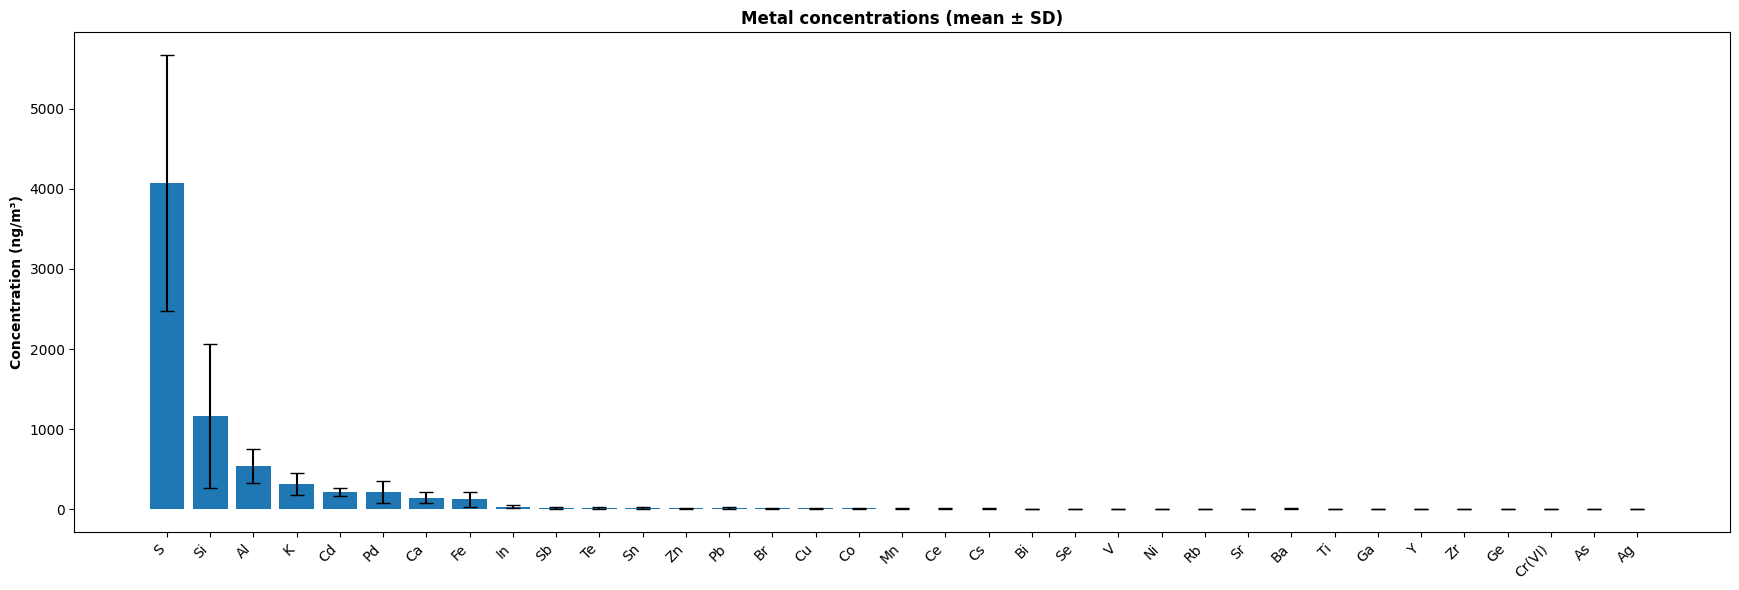

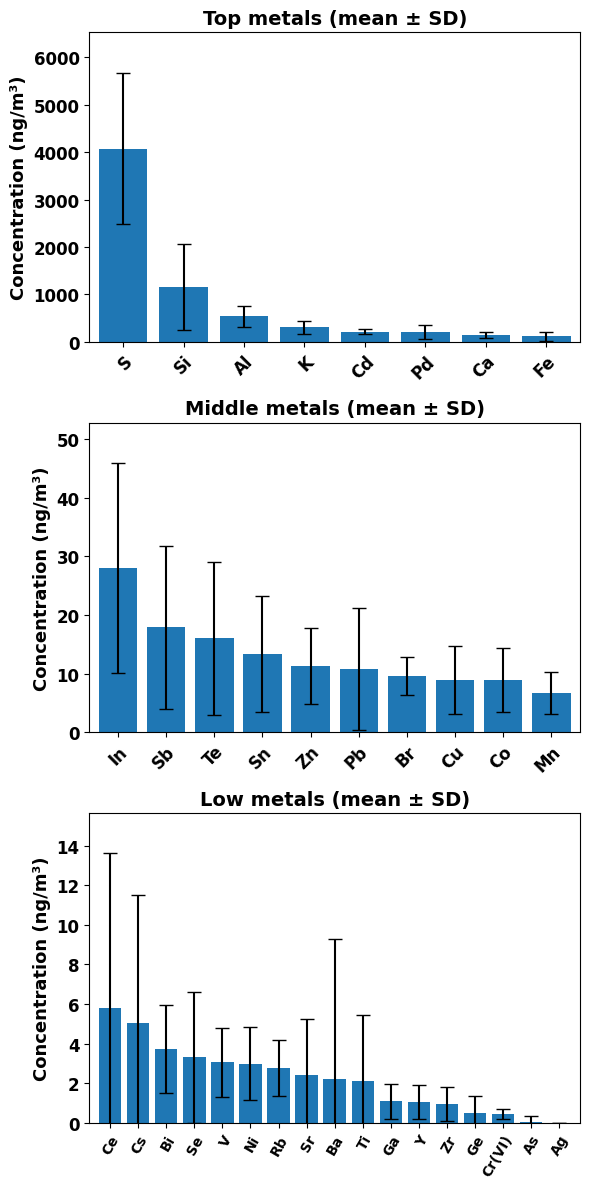

In [79]:
# === 설정값 =========================================================
UNIT = "ng"     # "ng" 또는 "ug"
EXCLUDE_KEYS = {"conc"}  # 비금속 패턴(소문자 비교)
K_TOP = 8                 # 상위 금속 개수
K_MID = 10                # 중간 금속 개수
# ===================================================================

import re, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# --- 유틸: 유닛 접미사 / 라벨에서 단위 제거용 정규식 ----------------
def unit_suffix(unit: str) -> str:
    """열 이름 접미사: (ng/m3) 또는 (ug/m3)"""
    return "(ng/m3)" if unit.lower() == "ng" else "(ug/m3)"

# x축 라벨에서 끝의 단위 괄호를 제거(ng/m3, ug/m3, µg/m3, 그리고 오타형 ngg/m3까지)
LABEL_UNIT_RE = re.compile(r'(?i)\s*\(\s*(?:n|u|µ)g{1,2}\s*/\s*m3\s*\)\s*$')

# --- 0) 열 이름 정규화: (ngg/m3)->(ng/m3), (ugg/m3)->(ug/m3) ----------
df.rename(columns=lambda c: re.sub(r'(?i)\(\s*ngg/m3\s*\)', '(ng/m3)', str(c)), inplace=True)
df.rename(columns=lambda c: re.sub(r'(?i)\(\s*ugg/m3\s*\)', '(ug/m3)', str(c)), inplace=True)

# --- 1) 금속 컬럼 엄격 추출 (Conc 등 비금속 제거) --------------------
def find_metal_cols(df):
    cols = []
    p = re.compile(r'^\s*([A-Z][a-z]?)\s*\((?:n|u|µ)g/m3\)\s*$', re.I)
    for c in df.columns:
        cs = str(c)
        if any(k in cs.lower() for k in EXCLUDE_KEYS):
            continue
        if p.match(cs):
            cols.append(cs)
    return cols

metal_cols = find_metal_cols(df)
if not metal_cols:
    raise ValueError("금속 농도 컬럼을 찾지 못함. 열 이름 패턴을 확인하세요.")

# --- 2) 단위 통일 (ng ↔ µg) -----------------------------------------
def unify_unit(df, cols, unit="ug"):
    out = []
    for c in cols:
        if "(ng/m3)" in c and unit == "ug":
            new = c.replace("(ng/m3)", "(ug/m3)")
            df[new] = pd.to_numeric(df[c], errors="coerce") / 1000.0
            out.append(new)
        elif "(ug/m3)" in c and unit == "ng":
            new = c.replace("(ug/m3)", "(ng/m3)")
            df[new] = pd.to_numeric(df[c], errors="coerce") * 1000.0
            out.append(new)
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            out.append(c)
    return df, [c for c in out if c in df.columns]

df, metal_cols = unify_unit(df, metal_cols, unit=UNIT)

# --- 3) Cr(VI)=Cr/7 생성, Cr 제거  (Cr(VI)는 제외하고 '순수 Cr'만 대상) ---
cr_only_pat = r'^\s*Cr(?!\s*\(VI\))\s*\(\s*(?:n|u|µ)\s*g/m3\s*\)\s*$'  # 대/소문자·공백 허용
cr_candidates = [c for c in metal_cols if re.match(cr_only_pat, c, flags=re.I)]
cr6_col = f"Cr(VI){unit_suffix(UNIT)}"  # 정확한 접미사 사용

if len(cr_candidates) > 0:
    cr_src = cr_candidates[0]
    df[cr6_col] = pd.to_numeric(df[cr_src], errors="coerce") / 7.0
    # 모든 '순수 Cr' 컬럼 제거
    metal_cols = [c for c in metal_cols if c not in cr_candidates]

# Cr(VI) 포함 보장
if cr6_col in df.columns and cr6_col not in metal_cols:
    metal_cols.append(cr6_col)

# --- 4) 음수 → NaN ---------------------------------------------------
metal_cols = [c for c in metal_cols if c in df.columns]
for c in metal_cols:
    df.loc[df[c] < 0, c] = np.nan

# --- 5) NaN만 있는 금속 제거 ----------------------------------------
metal_cols = [c for c in metal_cols if df[c].notna().any()]

# --- 6) 통계(Mean, SD, N) -------------------------------------------
means = df[metal_cols].mean(skipna=True)
stds  = df[metal_cols].std(skipna=True, ddof=1)
Ns    = df[metal_cols].notna().sum()

# --- 7) 평균 내림차순 정렬 ------------------------------------------
order = means.sort_values(ascending=False).index
means, stds, Ns = means[order], stds[order], Ns[order]

# --- 8) 단위 라벨 -----------------------------------------------------
unit_label = "ng/m³" if UNIT == "ng" else "µg/m³"

# --- 9) 요약표 (Mean & SD & N) ---------------------------------------
summary = pd.DataFrame({
    f"Mean ({unit_label})": means.round(6),
    f"SD ({unit_label})": stds.round(6),
    "N": Ns
})
display(summary)

# --- 11) 상·중·하 패널(모두 '세로 막대 + SD') -------------------------
names = list(means.index)
top_idx = names[:min(K_TOP, len(names))]
mid_idx = names[len(top_idx): len(top_idx) + min(K_MID, max(0, len(names)-len(top_idx)))]
low_idx = names[len(top_idx) + len(mid_idx):]

groups = [
    ("Top metals (mean ± SD)", top_idx),
    ("Middle metals (mean ± SD)", mid_idx),
    ("Low metals (mean ± SD)", low_idx)
]
groups = [(t, idx) for (t, idx) in groups if len(idx) > 0]

n_panels = len(groups)
fig, axes = plt.subplots(
    n_panels, 1,
    figsize=(max(6, 0.35 * max(len(g[1]) for g in groups)), 4*n_panels)  # 자동폭
)
if n_panels == 1:
    axes = [axes]

def plot_group(ax, idx, title):
    vals = means.loc[idx]; errs = stds.loc[idx]
    x = np.arange(len(idx))
    labels_local = [LABEL_UNIT_RE.sub('', s) for s in idx]  # 금속명만

    # 라벨 겹침 자동 완화(항목수에 따라 회전/크기 조정)
    n = len(labels_local)
    if n <= 12:
        rot, fs, step = 45, 12, 1
    elif n <= 18:
        rot, fs, step = 60, 10, 1
    else:
        rot, fs, step = 90, 9, 2  # 2개 중 1개만 표시

    tick_idx  = x[::step]
    tick_lbls = [labels_local[i] for i in range(0, n, step)]

    ax.bar(x, vals.values, yerr=errs.values, capsize=5)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_lbls, rotation=rot, ha='right',
                       fontsize=fs, fontweight='bold', rotation_mode='anchor')
    ax.set_ylabel(f"Concentration ({unit_label})", fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')

    ax.tick_params(axis='y', labelsize=12)
    for t in ax.get_yticklabels():
        t.set_fontweight('bold')

    ymax = float((vals + errs).max()) if len(vals) else 0.0
    if np.isfinite(ymax) and ymax > 0:
        ax.set_ylim(0, ymax * 1.15)
    ax.margins(x=0.02)  # 좌우 여백 약간

for i, (title, idx) in enumerate(groups):
    plot_group(axes[i], idx, title)

plt.tight_layout()
plt.show()


,Mean (ng/m³),SD (ng/m³),N
S(ng/m3),4073.717718,1598.946782,504
Si(ng/m3),1165.063790,903.284187,504
Al(ng/m3),535.974841,215.108460,504
K(ng/m3),311.862679,139.649319,504
Cd(ng/m3),215.833075,51.286357,504
Pd(ng/m3),208.696767,137.699417,464
Ca(ng/m3),143.558750,65.078443,504
Fe(ng/m3),122.621131,96.751470,504
In(ng/m3),27.986292,17.897314,480
Sb(ng/m3),17.861273,13.924933,267


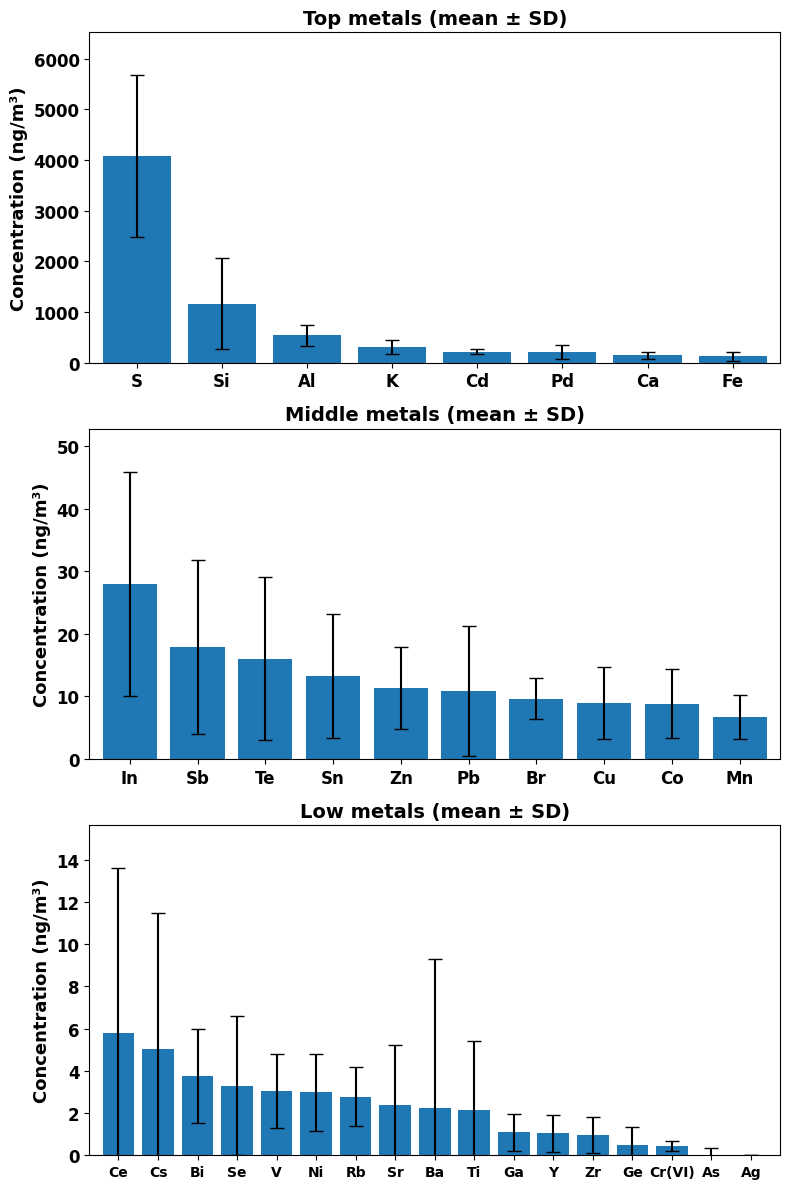

In [77]:
# === 설정값 =========================================================
UNIT = "ng"     # "ng" 또는 "ug"
EXCLUDE_KEYS = {"conc"}  # 비금속 패턴(소문자 비교)
K_TOP = 8                 # 상위 금속 개수
K_MID = 10                # 중간 금속 개수
# ===================================================================

import re, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# --- 유틸: 유닛 접미사 / 라벨에서 단위 제거용 정규식 ----------------
def unit_suffix(unit: str) -> str:
    """열 이름 접미사: (ng/m3) 또는 (ug/m3)"""
    return "(ng/m3)" if unit.lower() == "ng" else "(ug/m3)"

# x축 라벨에서 끝의 단위 괄호 제거(ng/m3, ug/m3, µg/m3, 그리고 오타형 ngg/m3까지)
LABEL_UNIT_RE = re.compile(r'(?i)\s*\(\s*(?:n|u|µ)g{1,2}\s*/\s*m3\s*\)\s*$')

# --- 0) 열 이름 정규화: (ngg/m3)->(ng/m3), (ugg/m3)->(ug/m3) ----------
df.rename(columns=lambda c: re.sub(r'(?i)\(\s*ngg/m3\s*\)', '(ng/m3)', str(c)), inplace=True)
df.rename(columns=lambda c: re.sub(r'(?i)\(\s*ugg/m3\s*\)', '(ug/m3)', str(c)), inplace=True)

# --- 1) 금속 컬럼 엄격 추출 (Conc 등 비금속 제거) --------------------
def find_metal_cols(df):
    cols = []
    p = re.compile(r'^\s*([A-Z][a-z]?)\s*\((?:n|u|µ)g/m3\)\s*$', re.I)
    for c in df.columns:
        cs = str(c)
        if any(k in cs.lower() for k in EXCLUDE_KEYS):
            continue
        if p.match(cs):
            cols.append(cs)
    return cols

metal_cols = find_metal_cols(df)
if not metal_cols:
    raise ValueError("금속 농도 컬럼을 찾지 못함. 열 이름 패턴을 확인하세요.")

# --- 2) 단위 통일 (ng ↔ µg) -----------------------------------------
def unify_unit(df, cols, unit="ug"):
    out = []
    for c in cols:
        if "(ng/m3)" in c and unit == "ug":
            new = c.replace("(ng/m3)", "(ug/m3)")
            df[new] = pd.to_numeric(df[c], errors="coerce") / 1000.0
            out.append(new)
        elif "(ug/m3)" in c and unit == "ng":
            new = c.replace("(ug/m3)", "(ng/m3)")
            df[new] = pd.to_numeric(df[c], errors="coerce") * 1000.0
            out.append(new)
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            out.append(c)
    return df, [c for c in out if c in df.columns]

df, metal_cols = unify_unit(df, metal_cols, unit=UNIT)

# --- 3) Cr(VI)=Cr/7 생성, Cr 제거  (Cr(VI)는 제외하고 '순수 Cr'만 대상) ---
cr_only_pat = r'^\s*Cr(?!\s*\(VI\))\s*\(\s*(?:n|u|µ)\s*g/m3\s*\)\s*$'  # 대/소문자·공백 허용
cr_candidates = [c for c in metal_cols if re.match(cr_only_pat, c, flags=re.I)]
cr6_col = f"Cr(VI){unit_suffix(UNIT)}"  # 정확한 접미사 사용

if len(cr_candidates) > 0:
    cr_src = cr_candidates[0]
    df[cr6_col] = pd.to_numeric(df[cr_src], errors="coerce") / 7.0
    # 모든 '순수 Cr' 컬럼 제거
    metal_cols = [c for c in metal_cols if c not in cr_candidates]

# Cr(VI) 포함 보장
if cr6_col in df.columns and cr6_col not in metal_cols:
    metal_cols.append(cr6_col)

# --- 4) 음수 → NaN ---------------------------------------------------
metal_cols = [c for c in metal_cols if c in df.columns]
for c in metal_cols:
    df.loc[df[c] < 0, c] = np.nan

# --- 5) NaN만 있는 금속 제거 ----------------------------------------
metal_cols = [c for c in metal_cols if df[c].notna().any()]

# --- 6) 통계(Mean, SD, N) -------------------------------------------
means = df[metal_cols].mean(skipna=True)
stds  = df[metal_cols].std(skipna=True, ddof=1)
Ns    = df[metal_cols].notna().sum()

# --- 7) 평균 내림차순 정렬 ------------------------------------------
order = means.sort_values(ascending=False).index
means, stds, Ns = means[order], stds[order], Ns[order]

# --- 8) 단위 라벨 -----------------------------------------------------
unit_label = "ng/m³" if UNIT == "ng" else "µg/m³"

# --- 9) 요약표 (Mean & SD & N) ---------------------------------------
summary = pd.DataFrame({
    f"Mean ({unit_label})": means.round(6),
    f"SD ({unit_label})": stds.round(6),
    "N": Ns
})
display(summary)

# --- 11) 상·중·하 패널(모두 '세로 막대 + SD', 라벨 전부 표시·회전 0°) -------
names = list(means.index)
top_idx = names[:min(K_TOP, len(names))]
mid_idx = names[len(top_idx): len(top_idx) + min(K_MID, max(0, len(names)-len(top_idx)))]
low_idx = names[len(top_idx) + len(mid_idx):]

groups = [
    ("Top metals (mean ± SD)", top_idx),
    ("Middle metals (mean ± SD)", mid_idx),
    ("Low metals (mean ± SD)", low_idx)
]
groups = [(t, idx) for (t, idx) in groups if len(idx) > 0]

n_panels = len(groups)
fig, axes = plt.subplots(
    n_panels, 1,
    figsize=(max(8, 0.35 * max(len(g[1]) for g in groups)), 4*n_panels)  # 자동폭(필요시 0.40)
)
if n_panels == 1:
    axes = [axes]

def plot_group(ax, idx, title):
    vals = means.loc[idx]; errs = stds.loc[idx]
    n = len(idx)
    labels_local = [LABEL_UNIT_RE.sub('', s) for s in idx]  # 금속명만
    fs = 12 if n <= 12 else (10 if n <= 18 else (9 if n <= 24 else 8))  # 전부 표시, 회전 0°

    x = np.arange(n)
    ax.bar(x, vals.values, yerr=errs.values, capsize=5)
    ax.set_xticks(x)
    ax.set_xticklabels(labels_local, rotation=0, ha='center',
                       fontsize=fs, fontweight='bold')
    ax.set_ylabel(f"Concentration ({unit_label})", fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')

    ax.tick_params(axis='y', labelsize=12)
    for t in ax.get_yticklabels():
        t.set_fontweight('bold')

    ymax = float((vals + errs).max()) if n else 0.0
    if np.isfinite(ymax) and ymax > 0:
        ax.set_ylim(0, ymax * 1.15)
    ax.margins(x=0.02)  # 좌우 여백

for i, (title, idx) in enumerate(groups):
    plot_group(axes[i], idx, title)

plt.tight_layout()
plt.show()
